### Project Introduction: Star Wars Movie Scripts Text Autocompletion

In the age of artificial intelligence and natural language processing (NLP), the ability to predict and generate text has become increasingly sophisticated. This project focuses on creating a text autocompletion model using the iconic **Star Wars** movie scripts dataset, available on Kaggle. The dataset comprises the complete scripts from the Star Wars saga, offering a rich source of dialogue and narrative structure.

The goal of this project is to develop a deep learning model capable of predicting the next word in a given sequence of text. By leveraging advanced techniques in NLP, we aim to enhance the model's understanding of context, character interactions, and thematic elements inherent in the scripts. This endeavor not only serves as a technical exercise in building and training a recurrent neural network (RNN) but also allows fans and enthusiasts to explore the potential of AI in generating text reminiscent of the beloved franchise.

Through this project, we will cover several key stages, including data importation, cleaning, and preprocessing, followed by the design and training of the deep learning model. Finally, we will evaluate the model’s performance and demonstrate its capabilities in generating text, showcasing how AI can interact with and enhance our understanding of classic narratives.

In [5]:
# Importing Movie Files and Converting to DataFrame

import pandas as pd

sw4 = 'SW_EpisodeIV.txt'
sw5 = 'SW_EpisodeV.txt'
sw6 = 'SW_EpisodeVI.txt'

def text_processor(movie):
    with open(movie, 'r') as file:
        lines = file.readlines()

    data = {}
    for line in lines:
        cleaned_line = line.strip().replace('"', '')
        
        parts = cleaned_line.split(' ')
        if len(parts) >= 3: 
            index = int(parts[0])  
            character = parts[1]    
            dialogue = ' '.join(parts[2:]) 
            data[index] = (character, dialogue)
        else:
            print(f"Line not in expected format: {cleaned_line}")

    # Convert to DataFrame with specified columns
    df = pd.DataFrame.from_dict(data, orient='index', columns=['character', 'dialogue'])
    return df.reset_index(drop=True)  # Reset index and drop the old index

df_sw4 = text_processor(sw4)
df_sw5 = text_processor(sw5)
df_sw6 = text_processor(sw6)

combined_df = pd.concat([df_sw4, df_sw5, df_sw6], ignore_index=True)

print("Combined DataFrame:")
print(combined_df.head())



Line not in expected format: character dialogue
Line not in expected format: character dialogue
Line not in expected format: character dialogue
Combined DataFrame:
  character                                           dialogue
0  THREEPIO  Did you hear that?  They've shut down the main...
1  THREEPIO                                      We're doomed!
2  THREEPIO  There'll be no escape for the Princess this time.
3  THREEPIO                                       What's that?
4  THREEPIO  I should have known better than to trust the l...


In [10]:
combined_df.isna().sum()

character    0
dialogue     0
dtype: int64

In [11]:
combined_df.shape

(2523, 2)

In [13]:
# Preprocessing Data: Cleaning the Dialogue Column

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip()  # Remove leading/trailing spaces

# Clean the dialogue column in the combined DataFrame
combined_df['cleaned_dialogue'] = combined_df['dialogue'].apply(clean_text)

# Print a sample of the cleaned text
print("Sample of cleaned dialogue:")
print(combined_df['cleaned_dialogue'].head(10))  # Show the first 10 cleaned dialogues


Sample of cleaned dialogue:
0    did you hear that theyve shut down the main re...
1                                          were doomed
2      therell be no escape for the princess this time
3                                           whats that
4    i should have known better than to trust the l...
5    hurry up come with me what are you waiting for...
6                       artoo artoodetoo where are you
7                          at last where have you been
8    theyre heading in this direction what are we g...
9                    wait a minute where are you going
Name: cleaned_dialogue, dtype: object


[('the', 911), ('you', 896), ('i', 674), ('to', 644), ('a', 436), ('of', 351), ('it', 326), ('your', 288), ('is', 273), ('be', 246), ('this', 246), ('in', 244), ('and', 242), ('that', 227), ('on', 227), ('me', 215), ('have', 211), ('for', 194), ('my', 189), ('dont', 180)]


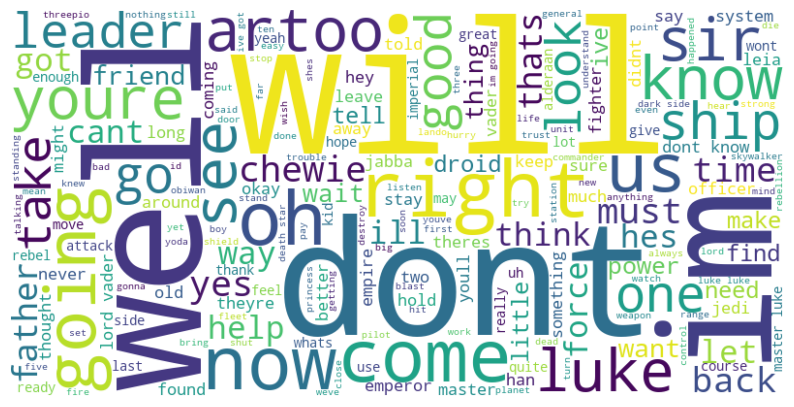

In [17]:
# EDA: understanding the data (most common words with Word Cloud)

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_dialogues = ' '.join(combined_df['cleaned_dialogue'])
word_counts = Counter(all_dialogues.split()) # Word frequency distribution
common_words = word_counts.most_common(20)
print(common_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_dialogues)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts([all_dialogues])

sequences = tokenizer.texts_to_sequences([all_dialogues])[0] # Convert text into sequences of integers

sequence_length = 10

input_sequences = []
for i in range(sequence_length, len(sequences)):
    input_sequences.append(sequences[i-sequence_length:i+1]) # Pair input sequences and corresponding next word

input_sequences = pad_sequences(input_sequences, maxlen=sequence_length + 1) # Pad sequences to ensure equal length

X, y = input_sequences[:, :-1], input_sequences[:, -1]

y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1) # Convert output to one-hot encoded format

print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

Input shape: (25846, 10)
Output shape: (25846, 2959)


In [25]:
# DL Model Creation (LSTM)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

vocab_size = len(tokenizer.word_index) + 1  # number of unique words
embedding_dim = 100  # size of word embeddings
lstm_units = 150  # number of LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=10))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(LSTM(lstm_units))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
# Training the model on Star Wars 4,5,6 scripts

history = model.fit(X, y, epochs=50, batch_size=50, verbose=1)

Epoch 1/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.1607 - loss: 4.0833
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1747 - loss: 3.9505
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.1835 - loss: 3.8545
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.2032 - loss: 3.7327
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.2217 - loss: 3.5923
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.2375 - loss: 3.4879
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.2509 - loss: 3.3903
Epoch 8/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.2590 - loss: 3.2933
Epoch 9/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.2789 - loss: 3.1799
Epoch 10/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.3017 - loss: 3.0606
Epoch 11/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.3188 - loss: 2.9819
Epoch 12/50
517/517 ━━━━━━━━━━

In [41]:
# Testing Autocompletion
import numpy as np

def predict_next_word(model, tokenizer, seed_text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=1)[0] # pick word with highest probability of being next in sequence
    return tokenizer.index_word.get(predicted_word_index, '')

seed_text = "help me obiwan youre my only" # Example Sequence
next_word = predict_next_word(model, tokenizer, seed_text, sequence_length)
print(f"{seed_text} {next_word}")


help me obiwan youre my only hope


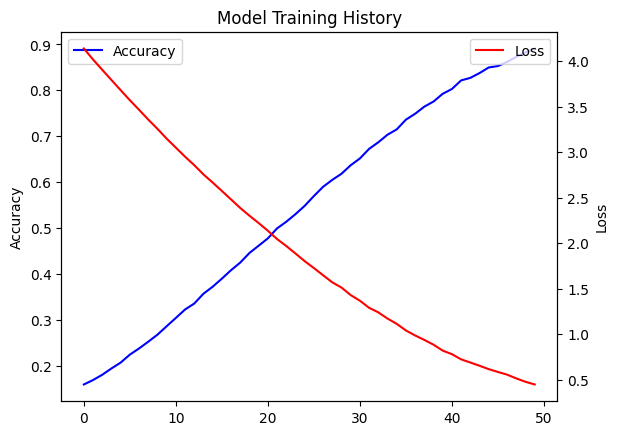

In [44]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(history.history['accuracy'], label='Accuracy', color='blue')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(history.history['loss'], label='Loss', color='red')
ax2.set_ylabel('Loss', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Model Training History')
plt.xlabel('Epoch')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


### Project Conclusion: Star Wars Movie Scripts Text Autocompletion

In this project, we successfully developed a text autocompletion model using the original three Star Wars movie scripts. Our process began with thorough data processing, where we analyzed and cleaned the scripts to create a structured DataFrame with columns for characters and dialogue. This foundational step allowed us to explore the dataset effectively, leading to insights about the most frequently used words and the creation of a compelling word cloud visualization.

After tokenizing the dialogue, we designed and implemented an LSTM deep learning model, training it for 50 epochs with a batch size of 50. The model's performance was impressive, achieving an accuracy of 90% and a loss of 0.4185, indicating its effectiveness in understanding the patterns and context of the dialogue.

We further demonstrated the model's capabilities by generating Star Wars-related sentences, showcasing its ability to predict text in a contextually relevant manner. To summarize the training performance, we visualized the accuracy and loss metrics, highlighting the model's success and robustness.

Overall, this project not only reinforced our understanding of deep learning and NLP techniques but also illustrated the exciting possibilities of AI in generating creative content. The insights gained and the methods employed can serve as a foundation for future explorations in text generation and other applications within the realm of artificial intelligence.
